**Modelo de red neuronal LSTM**

Este archivo consta de los codigos y conclusiones de:
* 1.Carga de librerias y datos
* 2.Normalizar Datos.
* 3.Preparar datos para realizar aprendizaje supervizado.
* 4.Modelo LSTM
* 5.Evaluacion del modelo


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [ ]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,model_from_json
from keras.layers import Dropout, LSTM, Dense, Activation,Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time

In [ ]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [ ]:
cd /content/gdrive/MyDrive/Tesis/Datos-2

/content/gdrive/MyDrive/Tesis/Datos-2


Se obtiene conjunto de datos

In [ ]:
df=pd.read_csv('df_EDA.csv',
                parse_dates={'dt':['Date','time']},
                infer_datetime_format=True,
                low_memory=False,
                index_col='dt')

In [ ]:
df=df[['Global_active_power','Global_intensity', 'Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2053263 entries, 2007-01-01 00:00:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_intensity       float64
 2   Global_reactive_power  float64
 3   Voltage                float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.3 MB


In [ ]:
df.shape

(2053263, 7)

In [ ]:
## resampling of data over hour
df = df.resample('D').mean()
df.shape

(1426, 7)

In [ ]:
#Setear semilla
np.random.seed(42)

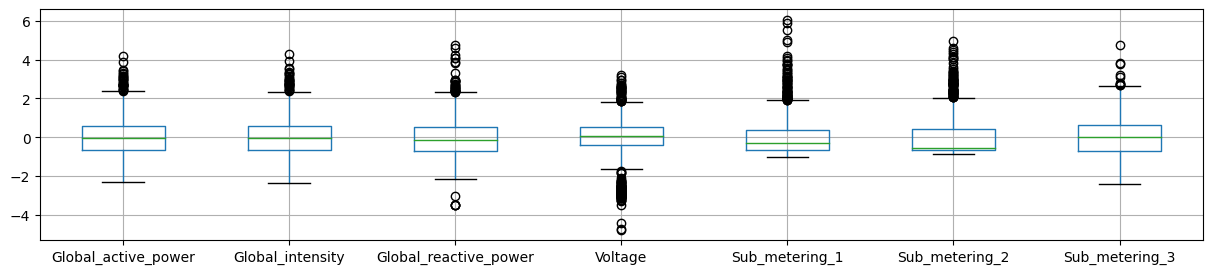

In [ ]:
def boxplot_data(dataframe):
  plt.figure(figsize = (15,3))
  dataframe.boxplot()
  plt.show()

boxplot_data(df)

In [ ]:
array=df.Global_active_power
array

In [ ]:
from scipy.stats.mstats import winsorize
array=np.array(df.Global_active_power)
WinsorizedArray = winsorize(array,(0.05,0.05))


In [ ]:
plt.boxplot(WinsorizedArray)
plt.title('Winsorized array')
plt.show()

In [ ]:
df_winsorized = df.apply(lambda col: winsorize(col, limits=[0.1, 0.1]))

In [ ]:
df_winsorized

,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2007-01-01,1.200231,1.207533,-0.579222,-0.344607,-1.006100,-0.715621,-0.877707
2007-01-02,-0.479665,-0.505030,0.254588,0.541014,-1.006100,-0.717544,-0.698740
2007-01-03,-0.913282,-0.919220,0.380838,1.029253,-1.006100,-0.719467,-1.170300
2007-01-04,1.200231,1.207533,0.491035,-0.529403,-0.344237,1.450161,0.438568
2007-01-05,1.200231,1.207533,-0.085215,-0.165616,-0.072187,-0.702637,-0.425828
...,...,...,...,...,...,...,...
2010-11-22,0.832664,0.855964,-0.694124,-0.311355,1.299401,0.129727,0.239133
2010-11-23,0.044213,0.063249,-0.791075,-0.126691,0.172155,-0.664650,-0.423466
2010-11-24,0.415859,0.403559,-0.889726,-0.392438,-0.315898,0.484599,0.787056


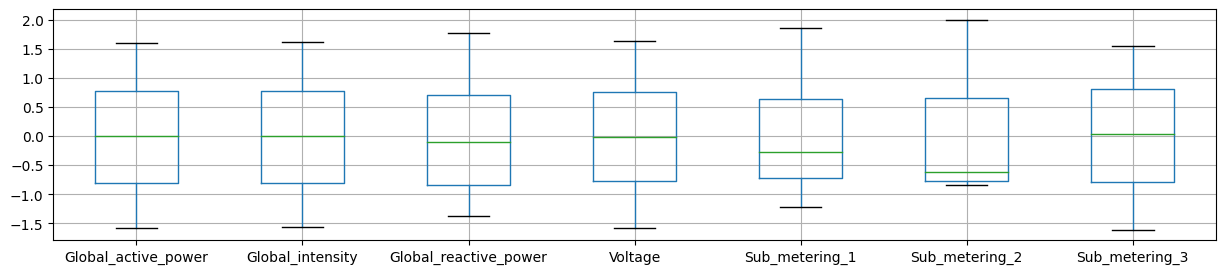

In [ ]:
def boxplot_data(dataframe):
  plt.figure(figsize = (15,3))
  dataframe.boxplot()
  plt.show()

boxplot_data(df)

#2.Normalizar base de datos

El **método de puntuación z** (a menudo llamado estandarización ) transforma los datos en una distribución con una media de 0 y una desviación estándar de 1 . Cada valor estandarizado se calcula restando la media de la característica correspondiente y luego dividiendo por la desviación estándar.

In [ ]:
#Seleccion de caracteristicas
features =df.columns

#Se define escalado
std_scaler = StandardScaler()
min_scaler=MinMaxScaler()

#Transformacion

for i in features:
  df[i] = std_scaler.fit_transform(df_winsorized[i].values.reshape(-1,1))

df.head()

,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2007-01-01,1.590862,1.610803,-0.677420,-0.714881,-1.213607,-0.820657,-1.031510
2007-01-02,-0.583374,-0.625977,0.378927,0.802477,-1.213607,-0.823162,-0.816823
2007-01-03,-1.144592,-1.166951,0.538872,1.638993,-1.213607,-0.825667,-1.382501
2007-01-04,1.590862,1.610803,0.678479,-1.031497,-0.331202,2.000238,0.547480
2007-01-05,1.590862,1.610803,-0.051566,-0.408212,0.031499,-0.803746,-0.489441


In [ ]:
round(df.describe(),5)


,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1426.00000,1426.00000,1426.00000,1426.00000,1426.00000,1426.00000,1426.00000
mean,0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000
std,1.00035,1.00035,1.00035,1.00035,1.00035,1.00035,1.00035
min,-2.27916,-2.34760,-3.50843,-4.75649,-1.00610,-0.88488,-2.42071
25%,-0.65932,-0.64112,-0.70868,-0.37564,-0.64100,-0.67811,-0.68418
50%,-0.02863,-0.02814,-0.12400,0.06225,-0.30677,-0.55766,0.00808
75%,0.56713,0.56233,0.51370,0.51078,0.37934,0.41944,0.65362
max,4.21108,4.28890,4.75205,3.22073,6.06217,4.93782,4.75898


#3.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [ ]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [ ]:
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=3, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

In [ ]:
serie_df = pd.concat(serie_split, axis=1).dropna()

In [ ]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('Global_active_power\(t\+')

In [ ]:
predictor_variables = serie_df.iloc[:, predictor_variables]
target_variables = serie_df.iloc[:, target_variables]

In [ ]:
predictor_variables

,Global_active_power(t-2),Global_active_power(t-1),Global_active_power(t-0),Global_intensity(t-2),Global_intensity(t-1),Global_intensity(t-0),Global_reactive_power(t-2),Global_reactive_power(t-1),Global_reactive_power(t-0),Voltage(t-2),...,Voltage(t-0),Sub_metering_1(t-2),Sub_metering_1(t-1),Sub_metering_1(t-0),Sub_metering_2(t-2),Sub_metering_2(t-1),Sub_metering_2(t-0),Sub_metering_3(t-2),Sub_metering_3(t-1),Sub_metering_3(t-0)
dt,,,,,,,,,,,,,,,,,,,,,
2007-01-04,1.590862,-0.583374,-1.144592,1.610803,-0.625977,-1.166951,-0.677420,0.378927,0.538872,-0.714881,...,1.638993,-1.213607,-1.213607,-1.213607,-0.820657,-0.823162,-0.825667,-1.031510,-0.816823,-1.382501
2007-01-05,-0.583374,-1.144592,1.590862,-0.625977,-1.166951,1.610803,0.378927,0.538872,0.678479,0.802477,...,-1.031497,-1.213607,-1.213607,-0.331202,-0.823162,-0.825667,2.000238,-0.816823,-1.382501,0.547480
2007-01-06,-1.144592,1.590862,1.590862,-1.166951,1.610803,1.610803,0.538872,0.678479,-0.051566,1.638993,...,-0.408212,-1.213607,-0.331202,0.031499,-0.825667,2.000238,-0.803746,-1.382501,0.547480,-0.489441
2007-01-07,1.590862,1.590862,-0.057434,1.610803,1.610803,0.015357,0.678479,-0.051566,0.425162,-1.031497,...,-1.096080,-0.331202,0.031499,-0.091920,2.000238,-0.803746,-0.789341,0.547480,-0.489441,-1.095098
2007-01-08,1.590862,-0.057434,1.590862,1.610803,0.015357,1.610803,-0.051566,0.425162,1.774800,-0.408212,...,-0.068150,0.031499,-0.091920,0.454650,-0.803746,-0.789341,2.000238,-0.489441,-1.095098,1.149989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-22,0.078970,1.457053,-1.393427,0.042084,1.505721,-1.457618,-1.309535,-0.537111,-1.371449,-0.783628,...,0.164043,-1.213607,1.860118,-1.213607,-0.738610,0.804614,-0.724205,0.867936,0.716522,-1.378409
2010-11-23,1.457053,-1.393427,1.115131,1.505721,-1.457618,1.151619,-0.537111,-1.371449,-0.822988,-0.314092,...,-0.657910,1.860118,-1.213607,1.860118,0.804614,-0.724205,0.280394,0.716522,-1.378409,0.308239
2010-11-24,-1.393427,1.115131,0.094664,-1.457618,1.151619,0.116253,-1.371449,-0.822988,-0.945814,0.164043,...,-0.341521,-1.213607,1.860118,0.357258,-0.724205,0.280394,-0.754268,-1.378409,0.308239,-0.486607


In [ ]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape_x_test=X_test.shape
shape_y_test=Y_test.shape

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0], 1, Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

#5.LSTM

In [ ]:
# Ajustar parámetros para reproducibilidad del entrenamiento
#tf.random.set_seed(123)
keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [ ]:
# Función para crear el modelo LSTM
def create_model(neurons, dropout,layers,learning_rate):

    #Creacion de la arquitectura LSTM
    model = Sequential()
    #Capas ocultas
    for i in range(layers):
        model.add(LSTM(units=neurons, return_sequences=(layers-1), activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
        model.add(Dropout(dropout))
    #Capa de salida
    model.add(Dense(1))

    #Se configura el proceso de entrenamiento del modelo y metricas de evaluacion
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()]
                  )
    return model

In [ ]:
def objective(params):
    # Definir los hiperparámetros a optimizar
    epochs = params['epochs']
    batch_size = params['batch_size']
    optimizer = params['optimizer']
    neurons  = params['neurons']
    dropout  = params['dropout']
    layers  = params['layers']
    learning_rate = params['learning_rate']

    # Crear el modelo de LSTM


    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    times=[]
    models=[]
    scores_test=[]

    #Se detiene el entrenamiento en el momento que se observe un incremento en el valor del error de validación.
    early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min',restore_best_weights=True)

    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train[train_index], X_train[test_index]
      y_train_, y_test_ = Y_train_s[train_index], Y_train_s[test_index]

      model = create_model(int(neurons), float(dropout),int(layers),float(learning_rate))
      #Entrenamiento
      start = time.time()
      hist=model.fit(X_train_, y_train_, batch_size=int(batch_size), epochs=int(epochs), verbose=0, validation_data=(X_test_, y_test_),callbacks=[early_stop],use_multiprocessing=True)
      end = time.time()

      #Evaluacion del modelo
      score = model.evaluate(X_test_, y_test_, verbose = 0)
      scores.append(score)
      #Error en conjunto de test
      score_test = model.evaluate(X_test, Y_test, verbose = 0)
      scores_test.append(score_test)

      #guardar modelo keras
      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(scores),
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'time':times,
            'hist':hist,
            'scores_test': scores_test,
            'scores': scores,
            'models':models}

In [ ]:

#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 800,
    'batch_size':  hp.quniform('batch_size', 10, 100, 10),
    'optimizer':'adam',
    'neurons': hp.quniform('neurons', 100, 800, 20),
    'dropout':hp.uniform('dropout', 0.4, 0.7),
    'layers': hp.quniform('layers', 1, 3, 1),
    'learning_rate': hp.uniform('learning_rate', 0.00001, 0.00005)
}


In [ ]:

#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 800,
    'batch_size': 20,
    'optimizer':'adam',
    'neurons': 500,
    'dropout':0.5,
    'layers':1,
    'learning_rate': 0.00005
}

In [ ]:
trials = Trials()
#Optimización bayesiana
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=1, trials=trials)
print("Modelo entrenado 1!")

100%|██████████| 1/1 [01:59<00:00, 119.86s/trial, best loss: 143.96170980930327]
Modelo entrenado 1!


In [ ]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
hist = best_trial['result']['hist']
best_model = best_trial['result']['model']
scores_model = best_trial['result']['scores_test']

In [ ]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

In [ ]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'batch_size': 20,
 'dropout': 0.5,
 'epochs': 800,
 'layers': 1,
 'learning_rate': 5e-05,
 'neurons': 500,
 'optimizer': 'adam'}

In [ ]:
#Metricas de precision del modelo keras
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.47680386900901794
RMSE: 0.6905098557472229
MAE: 0.5233868956565857
MAPE: 371.75262451171875


# 6.Evaluacion del modelo

In [ ]:
#Metricas de precision del modelo keras
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.47680386900901794
RMSE: 0.6905098557472229
MAE: 0.5233868956565857
MAPE: 371.75262451171875


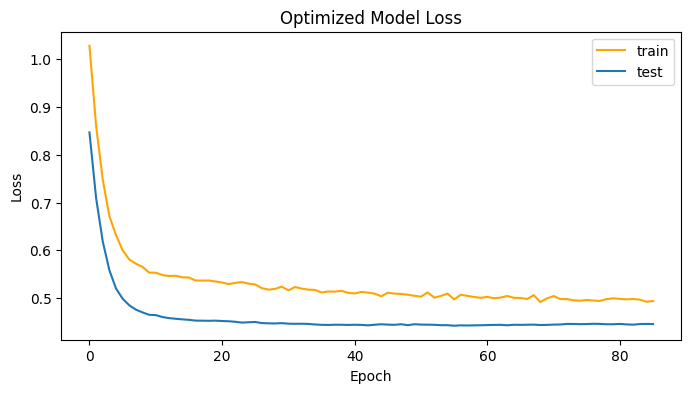

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], color = 'orange')
plt.plot(hist.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
#Se realiza prediccion
results = best_model.predict(X_test)

results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

9/9 [==============================] - 0s 2ms/step


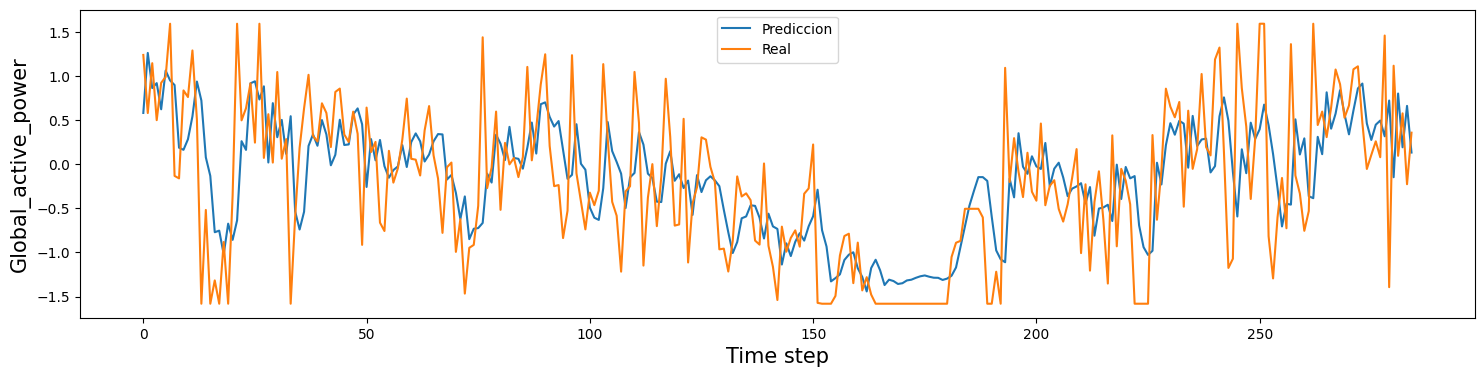

In [ ]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(18,4))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

#Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [ ]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for time in result['time']:
    k+=1
    nameModel = "LSTM_CE" + "_"+str(trial)+"_"+str(k) + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    results.append([nameModel,trial,k,time,
                    result['scores_test'][i][0],result['scores_test'][i][2],result['scores_test'][i][3],result['scores_test'][i][4]]
                   )
    i+=1

In [ ]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

In [ ]:
results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
139,LSTM_CE_800_10.0_1.0_680.0_0.52_adam_3.1458576...,28,5,36.681360,0.378168,0.614954,0.455236,220.871017
319,LSTM_CE_800_10.0_1.0_640.0_0.42_adam_4.4268419...,64,5,28.392772,0.379389,0.615946,0.456227,220.155869
299,LSTM_CE_800_20.0_1.0_780.0_0.68_adam_4.2855902...,60,5,23.493317,0.380622,0.616946,0.457438,223.087753
94,LSTM_CE_800_30.0_1.0_620.0_0.55_adam_3.4341560...,19,5,20.831620,0.380932,0.617197,0.456960,224.679672
499,LSTM_CE_800_20.0_2.0_480.0_0.54_adam_1.6602774...,100,5,51.668610,0.380971,0.617228,0.457549,221.807846


In [ ]:
# Exportar el DataFrame como CSV
results_csv.to_csv('results_LSTM_CE_2.csv')

Se guarda cada modelo keras en un objeto Json

In [ ]:
import os
# Ruta de la carpeta que deseas crear
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_lstm'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

In [ ]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for model in result['models']:
    k+=1
    nameModel = "LSTM_CE"+"_"+str(trial)+"_"+str(k) + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    model_json = model.to_json()
    ruta = os.path.join(carpeta_destino, nameModel + ".json")
    with open(ruta, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    save_w=nameModel+"."+"h5"
    weights_path = os.path.join(carpeta_destino, save_w)
    model.save_weights(weights_path)
    i+=1